In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dl-course-data/ion.csv
/kaggle/input/dl-course-data/spotify.csv
/kaggle/input/dl-course-data/forestfires.csv
/kaggle/input/dl-course-data/songs.csv
/kaggle/input/dl-course-data/abalone.csv
/kaggle/input/dl-course-data/concrete.csv
/kaggle/input/dl-course-data/fuel.csv
/kaggle/input/dl-course-data/red-wine.csv
/kaggle/input/dl-course-data/hotel.csv
/kaggle/input/dl-course-data/diamonds.csv
/kaggle/input/dl-course-data/candy.csv
/kaggle/input/dl-course-data/cereal.csv
/kaggle/input/dl-course-data/housing.csv


## Import required library, and datasets

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

ion = pd.read_csv('../input/dl-course-data/ion.csv', index_col=0)
ion.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V26,V27,V28,V29,V30,V31,V32,V33,V34,Class
1,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,good
2,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,bad
3,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,good
4,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,bad
5,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,good


## initial PDA and data cleaning

In [3]:
df = ion.copy()
df['Class'] = df['Class'].map({'good': 0, 'bad': 1})

df_train = df.sample(frac=0.7, random_state=42)
df_valid = df.drop(df_train.index)

max_ = df_train.max(axis=0)
min_ = df_train.min(axis=0)

df_train = (df_train - min_) / (max_ - min_)
df_valid = (df_valid - min_) / (max_ - min_)
df_train.dropna(axis=1, inplace=True)  # drop the empty feature in column 2
df_valid.dropna(axis=1, inplace=True)

## Spliting data into training and validation

In [4]:
X_train = df_train.drop('Class', axis=1)
X_valid = df_valid.drop('Class', axis=1)
y_train = df_train['Class']
y_valid = df_valid['Class']

## Creating the model 

In [5]:
model = keras.Sequential([
    layers.BatchNormalization(input_shape=[33]),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid'),
])

2022-07-22 10:30:50.539059: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Initilizing hyperparameters and callback functions

In [6]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=20,
    min_delta=0.001,
    restore_best_weights=True,
)

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 33)                132       
_________________________________________________________________
dense (Dense)                (None, 512)               17408     
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

## Fitting the model 

In [8]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=1000,
    callbacks=[early_stopping],
    verbose=0,  # hide the output because we have so many epochs
)

2022-07-22 10:30:51.095723: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


## Visulizing the model paramaters, and ploting loss and accuracy 

Best Validation Loss: 0.6007
Best Validation Accuracy: 0.7048


<AxesSubplot:title={'center':'Accuracy'}>

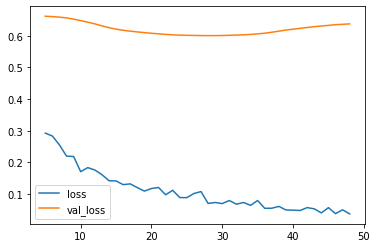

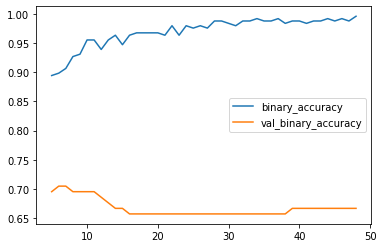

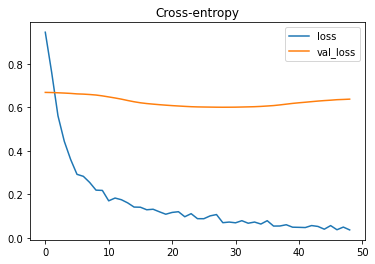

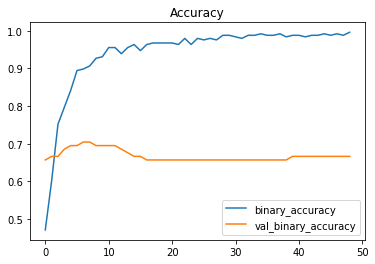

In [9]:
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" + \
       "\nBest Validation Accuracy: {:0.4f}") \
      .format(history_df['val_loss'].min(),
              history_df['val_binary_accuracy'].max()))

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")